In [5]:
pip install mne

  Using cached mne-1.9.0-py3-none-any.whl.metadata (20 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
Using cached mne-1.9.0-py3-none-any.whl (7.4 MB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached MarkupSafe-3.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (23 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [mne]4/5 [mne]a2]
Note: you may need to restart the kernel to use updated packages.


In [6]:
import mne
print(f"MNE-Python version: {mne.__version__}")

MNE-Python version: 1.9.0


In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import mne
from mne.filter import filter_data, notch_filter
from scipy.signal import welch

Creating RawArray with float64 data, n_channels=8, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     4.998 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 0.50

/tmp/ipykernel_50955/784448537.py:28: RuntimeWarning: filter_length (3301) is longer than the signal (2500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.notch_filter(np.array([50]))  # Sólo 50 Hz
/tmp/ipykernel_50955/784448537.py:40: RuntimeWarning: filter_length (6600) is longer than the signal (2500), distortion is likely. Reduce filter length or filter a longer signal.
  filtered[band] = raw.copy().filter(


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 1016 samples (2.032 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-12 dB cu

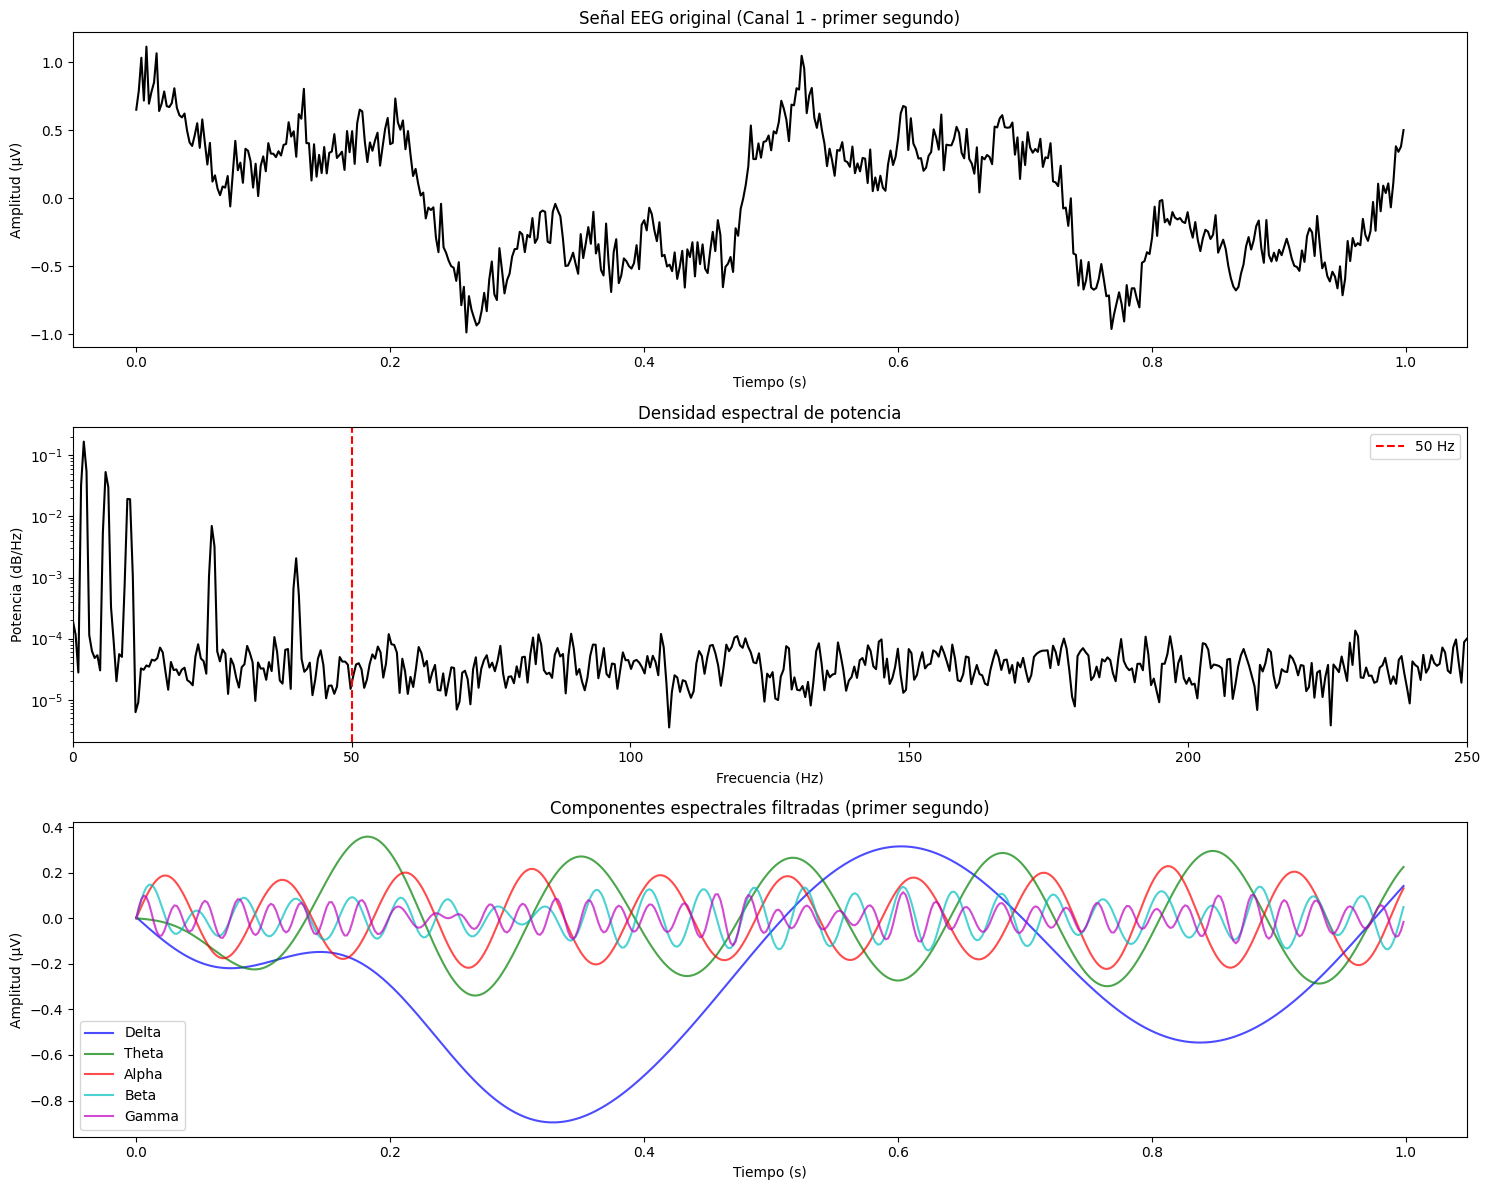

In [9]:
# Configuración con una frecuencia de muestreo más alta
sample_rate = 500  # Aumentado a 500 Hz para permitir el filtrado gamma
np.random.seed(42)

def simulate_eeg(duration=10, n_channels=8):
    n_samples = int(duration * sample_rate)
    time = np.linspace(0, duration, n_samples)

    # Componentes cerebrales con más variabilidad
    signals = [
        0.5 * np.sin(2 * np.pi * 2 * time + np.random.rand()),    # Delta
        0.3 * np.sin(2 * np.pi * 6 * time + np.random.rand()),    # Theta
        0.2 * np.sin(2 * np.pi * 10 * time + np.random.rand()),   # Alpha
        0.1 * np.sin(2 * np.pi * 25 * time + np.random.rand()),   # Beta
        0.05 * np.sin(2 * np.pi * 40 * time + np.random.rand())   # Gamma
    ]

    clean_eeg = sum(signals)
    noise = 0.1 * np.random.randn(n_samples, n_channels)
    eeg_data = clean_eeg[:, np.newaxis] + noise

    info = mne.create_info(n_channels, sample_rate, ch_types='eeg')
    raw = mne.io.RawArray(eeg_data.T, info)
    return raw, time

def filter_eeg(raw):
    # Filtro notch solamente a 50 Hz (armónicos debajo de Nyquist)
    raw.notch_filter(np.array([50]))  # Sólo 50 Hz

    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 45)  # Limitado a 45 Hz para mantenerse debajo de Nyquist
    }

    filtered = {}
    for band, (l_freq, h_freq) in bands.items():
        filtered[band] = raw.copy().filter(
            l_freq, h_freq,
            method='fir',
            fir_window='hamming',
            phase='zero-double',
            fir_design='firwin2'
        )

    return filtered

def plot_results(raw, filtered, time):
    plt.figure(figsize=(15, 12))

    # Señal original
    plt.subplot(3, 1, 1)
    plt.plot(time[:500], raw.get_data()[0, :500], 'k')  # Solo el primer segundo
    plt.title('Señal EEG original (Canal 1 - primer segundo)')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (µV)')

    # Densidad espectral de potencia
    plt.subplot(3, 1, 2)
    f, Pxx = welch(raw.get_data()[0], fs=sample_rate, nperseg=1024)
    plt.semilogy(f, Pxx, 'k')
    plt.axvline(x=50, color='r', linestyle='--', label='50 Hz')
    plt.title('Densidad espectral de potencia')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Potencia (dB/Hz)')
    plt.xlim(0, sample_rate/2)
    plt.legend()

    # Señales filtradas (primer segundo)
    plt.subplot(3, 1, 3)
    colors = {'Delta':'b', 'Theta':'g', 'Alpha':'r', 'Beta':'c', 'Gamma':'m'}
    for band, color in colors.items():
        data = filtered[band].get_data()[0, :500]
        plt.plot(time[:500], data, color, label=band, alpha=0.7)
    plt.title('Componentes espectrales filtradas (primer segundo)')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (µV)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Ejecución
raw, time = simulate_eeg(duration=5)  # Duración reducida para la demostración
filtered = filter_eeg(raw)
plot_results(raw, filtered, time)


Creating RawArray with float64 data, n_channels=10, n_times=221
    Range : 0 ... 220 =      0.000 ...     0.880 secs
Ready.
Nettoyage des NaN/Inf trouvés dans les données
Creating RawArray with float64 data, n_channels=10, n_times=221
    Range : 0 ... 220 =      0.000 ...     0.880 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 44001 samples (176.004 s)



/tmp/ipykernel_41877/3646695875.py:60: RuntimeWarning: filter_length (44001) is longer than the signal (221), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5, 45,


Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 10 PCA components
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/home/erick-mpangi/Documents/exerices-python/.venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_41877/3646695875.py:99: RuntimeWarning: filter_length (413) is longer than the signal (221), distortion is likely. Reduce filter length or filter a longer signal.
  raw_band.filter(None, h_freq, fir_design='firwin', filter_length='auto')
/tmp/ipykernel_41877/3646695875.py:103: RuntimeWarning: filter_length (413) is longer than the signal (221), distortion is likely. Reduce filter length or filter a longer signal.
  raw_band.filter(l_freq, h_freq, fir_design='firwin', filter_length='auto')
/tmp/ipykernel_41877/3646695875.py:103: RuntimeWarning: filter_length (413) is longer than the signal (221), distortion is likely. Reduce filter length or filter a longer signal.
  raw_band.filter(l_freq, h_freq, fir_design='firwin', filter_l

Analyse terminée avec succès !


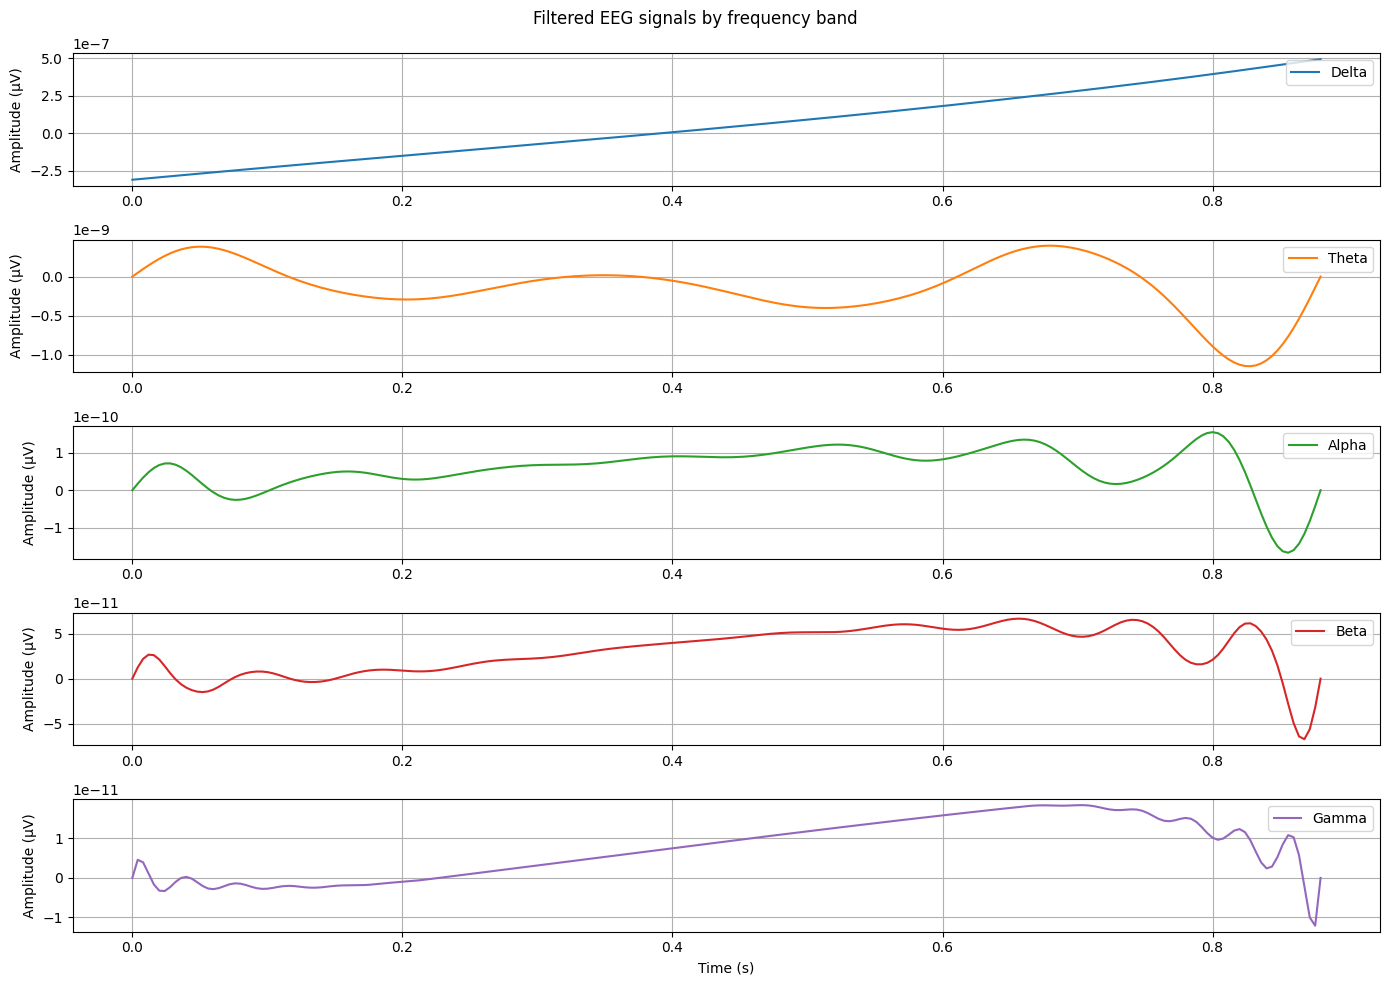

Bands enregistrées dans : ./band_outputs


In [3]:
# %matplotlib inline  # Décommente cette ligne si tu es dans Jupyter Notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import os

# 1. Charger les données EEG à partir d'un fichier CSV
def load_eeg_from_csv(file_path='/home/erick-mpangi/Documents/exerices-python/Jupyter/1.csv', sfreq=250, ch_names=None):
    data = pd.read_csv(file_path)

    # Filtrer les colonnes contenant uniquement des valeurs numériques
    numeric_data = data.select_dtypes(include=[np.number])

    if numeric_data.empty:
        raise ValueError("Le fichier CSV ne contient pas de colonnes numériques.")

    eeg_data = numeric_data.astype(float).values.T * 1e-6  # μV -> V (MNE utilise les volts)

    # Générer dynamiquement les noms des canaux si non fournis
    if ch_names is None:
        ch_names = [f'EEG{i+1}' for i in range(eeg_data.shape[0])]

    if eeg_data.shape[0] != len(ch_names):
        raise ValueError(f"Le nombre de canaux ({eeg_data.shape[0]}) ne correspond pas à len(ch_names) ({len(ch_names)}).")

    info = mne.create_info(
        ch_names=ch_names,
        sfreq=sfreq,
        ch_types=['eeg'] * len(ch_names)
    )

    raw = mne.io.RawArray(eeg_data, info)
    return raw

# 2. Prétraitement EEG
def preprocess_eeg(raw):
    # 1. Vérifier et nettoyer les données
    if 'eeg' not in raw:
        raw.set_channel_types({raw.ch_names[0]: 'eeg'})
    
    # Supprimer les NaN/Inf s'ils existent
    data = raw.get_data()
    if np.any(~np.isfinite(data)):
        print("Nettoyage des NaN/Inf trouvés dans les données")
        data[~np.isfinite(data)] = 0  # Remplacer par 0 ou une autre valeur
        raw = mne.io.RawArray(data, raw.info)
    
    # 2. Ajustement spécial pour les signaux courts
    max_filter_length = min(
        1000,  # Longueur maximale absolue
        int(raw.times[-1] * raw.info['sfreq'] * 0.8)  # 80% de la longueur du signal
    )
    
    # 3. Appliquer le filtre avec des paramètres adaptés
    try:
        raw.filter(0.5, 45, 
                 fir_design='firwin',
                 filter_length=f"{max_filter_length}s",
                 l_trans_bandwidth=0.5,
                 h_trans_bandwidth=11.25)
    except Exception as e:
        print(f"Erreur de filtrage : {e}")
        # Solution de secours pour les très courts signaux
        raw.filter(0.5, 45, method='iir')  # Filtre IIR plus adapté aux signaux courts
    
    # 4. ICA adaptée aux petits datasets
    n_components = min(5, len(raw.ch_names))  # Réduire le nombre de composantes
    try:
        ica = ICA(n_components=n_components, random_state=97, max_iter=200)
        ica.fit(raw.copy().crop(0, min(30, raw.times[-1])))  # Limiter la durée pour ICA
        ica.apply(raw)
    except Exception as e:
        print(f"Erreur ICA : {e}. Poursuite sans ICA.")
    
    return raw
# 3. Bandes EEG à extraire
EEG_BANDS = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 45)
}

# 4. Analyse EEG (filtrage, PSD)
def analyze_eeg_data(csv_path):
    try:
        raw = load_eeg_from_csv(csv_path, sfreq=250)  # plus besoin de ch_names manuels
        raw = preprocess_eeg(raw)

        bands_data = {}
        for band, (l_freq, h_freq) in EEG_BANDS.items():
            raw_band = raw.copy()
            if l_freq < 1:
                raw_band.filter(None, h_freq, fir_design='firwin', filter_length='auto')
            elif h_freq > 40:
                raw_band.filter(l_freq, None, fir_design='firwin', filter_length='auto')
            else:
                raw_band.filter(l_freq, h_freq, fir_design='firwin', filter_length='auto')
            bands_data[band] = raw_band.get_data()

        psds, freqs = {}, {}
        for band, data in bands_data.items():
            freqs[band], psds[band] = welch(data, raw.info['sfreq'], nperseg=min(256, data.shape[-1]//2))

        return raw, bands_data, psds, freqs
    except Exception as e:
        print(f"Erreur : {str(e)}")
        return None

# 5. Tracer les signaux EEG dans le temps
def plot_time_series(bands_data, sfreq):
    time = np.arange(bands_data['Alpha'].shape[-1]) / sfreq  # Axe des temps

    plt.figure(figsize=(14, 10))
    for i, (band, signal) in enumerate(bands_data.items()):
        signal_1d = signal[0] if signal.ndim == 2 else signal
        plt.subplot(len(bands_data), 1, i + 1)
        plt.plot(time, signal_1d, label=f'{band}', color=f'C{i}')
        plt.ylabel('Amplitude (µV)')
        plt.legend(loc='upper right')
        plt.grid(True)

    plt.xlabel('Time (s)')
    plt.suptitle('Filtered EEG signals by frequency band')
    plt.tight_layout()
    plt.show()

# 6. Sauvegarde optionnelle des signaux filtrés
def save_filtered_bands(bands_data, output_dir='./band_outputs'):
    os.makedirs(output_dir, exist_ok=True)
    for band, signal in bands_data.items():
        filename = os.path.join(output_dir, f'{band}_band.csv')
        pd.DataFrame(signal.T).to_csv(filename, index=False)
    print(f"Bands enregistrées dans : {output_dir}")

# 7. Exécution principale
if __name__ == "__main__":
    csv_path = '/home/erick-mpangi/Documents/exerices-python/Jupyter/1.csv'
    results = analyze_eeg_data(csv_path)

    if results:
        raw, bands_data, psds, freqs = results
        print("Analyse terminée avec succès !")
        plot_time_series(bands_data, raw.info['sfreq'])
        save_filtered_bands(bands_data)

Creating RawArray with float64 data, n_channels=10, n_times=297
    Range : 0 ... 296 =      0.000 ...     1.184 secs


Ready.
Nettoyage des NaN/Inf trouvés dans les données
Creating RawArray with float64 data, n_channels=10, n_times=297
    Range : 0 ... 296 =      0.000 ...     1.184 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 59001 samples (236.004 s)



/tmp/ipykernel_41877/838306205.py:60: RuntimeWarning: filter_length (59001) is longer than the signal (297), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5, 45,


Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 10 PCA components
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/home/erick-mpangi/Documents/exerices-python/.venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_41877/838306205.py:99: RuntimeWarning: filter_length (413) is longer than the signal (297), distortion is likely. Reduce filter length or filter a longer signal.
  raw_band.filter(None, h_freq, fir_design='firwin', filter_length='auto')
/tmp/ipykernel_41877/838306205.py:103: RuntimeWarning: filter_length (413) is longer than the signal (297), distortion is likely. Reduce filter length or filter a longer signal.
  raw_band.filter(l_freq, h_freq, fir_design='firwin', filter_length='auto')
/tmp/ipykernel_41877/838306205.py:103: RuntimeWarning: filter_length (413) is longer than the signal (297), distortion is likely. Reduce filter length or filter a longer signal.
  raw_band.filter(l_freq, h_freq, fir_design='firwin', filter_leng

Analyse terminée avec succès !


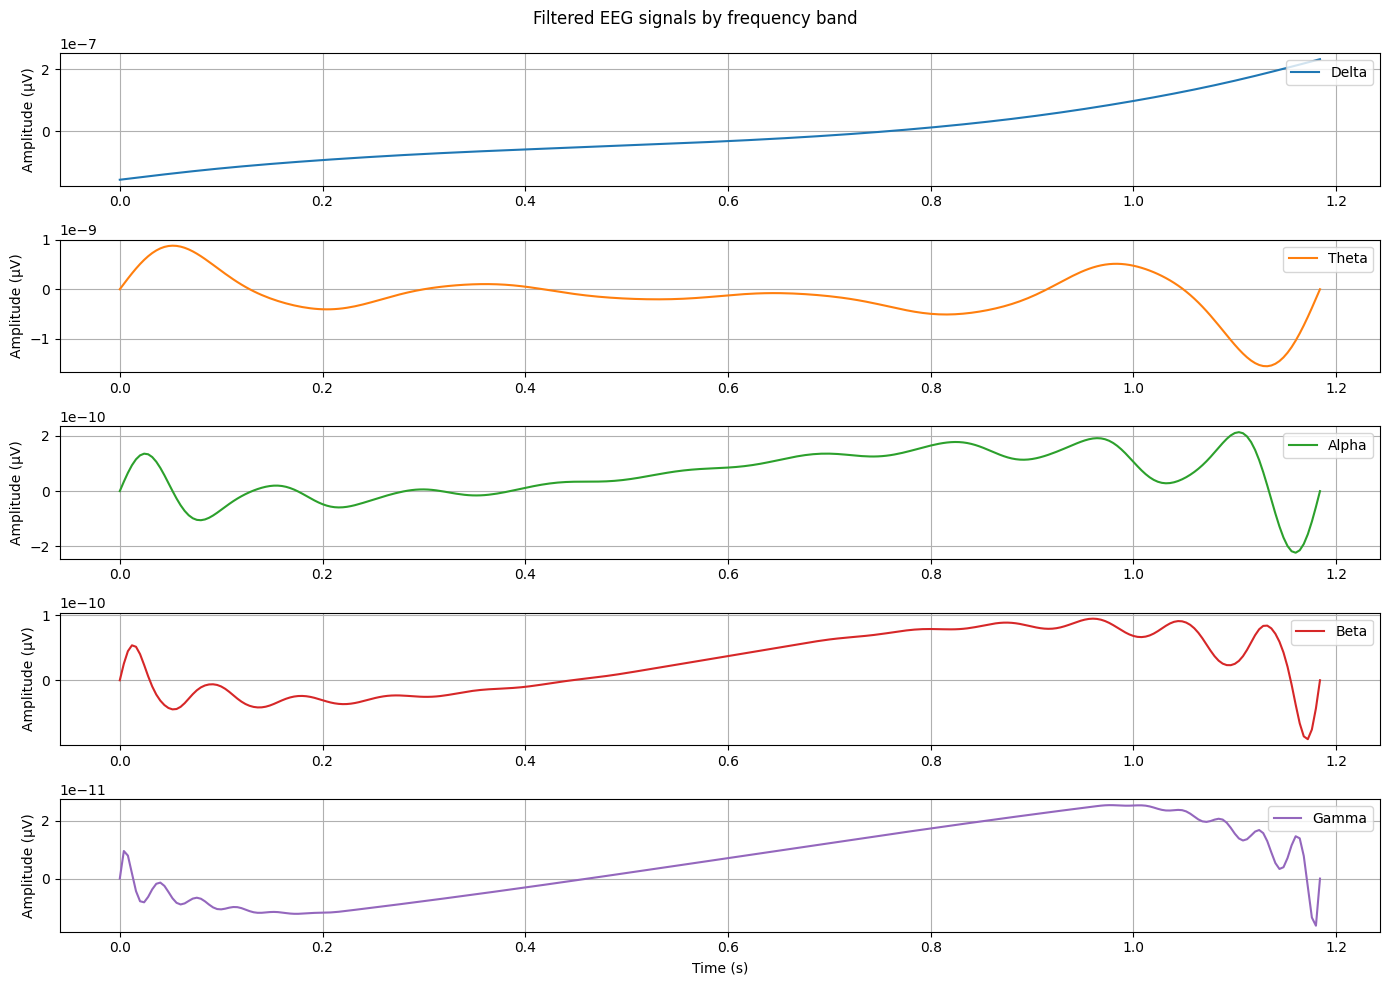

Bands enregistrées dans : ./band_outputs


In [4]:
# %matplotlib inline  # Décommente cette ligne si tu es dans Jupyter Notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import os

# 1. Charger les données EEG à partir d'un fichier CSV
def load_eeg_from_csv(file_path='/home/erick-mpangi/Documents/exerices-python/Jupyter/2.csv', sfreq=250, ch_names=None):
    data = pd.read_csv(file_path)

    # Filtrer les colonnes contenant uniquement des valeurs numériques
    numeric_data = data.select_dtypes(include=[np.number])

    if numeric_data.empty:
        raise ValueError("Le fichier CSV ne contient pas de colonnes numériques.")

    eeg_data = numeric_data.astype(float).values.T * 1e-6  # μV -> V (MNE utilise les volts)

    # Générer dynamiquement les noms des canaux si non fournis
    if ch_names is None:
        ch_names = [f'EEG{i+1}' for i in range(eeg_data.shape[0])]

    if eeg_data.shape[0] != len(ch_names):
        raise ValueError(f"Le nombre de canaux ({eeg_data.shape[0]}) ne correspond pas à len(ch_names) ({len(ch_names)}).")

    info = mne.create_info(
        ch_names=ch_names,
        sfreq=sfreq,
        ch_types=['eeg'] * len(ch_names)
    )

    raw = mne.io.RawArray(eeg_data, info)
    return raw

# 2. Prétraitement EEG
def preprocess_eeg(raw):
    # 1. Vérifier et nettoyer les données
    if 'eeg' not in raw:
        raw.set_channel_types({raw.ch_names[0]: 'eeg'})
    
    # Supprimer les NaN/Inf s'ils existent
    data = raw.get_data()
    if np.any(~np.isfinite(data)):
        print("Nettoyage des NaN/Inf trouvés dans les données")
        data[~np.isfinite(data)] = 0  # Remplacer par 0 ou une autre valeur
        raw = mne.io.RawArray(data, raw.info)
    
    # 2. Ajustement spécial pour les signaux courts
    max_filter_length = min(
        1000,  # Longueur maximale absolue
        int(raw.times[-1] * raw.info['sfreq'] * 0.8)  # 80% de la longueur du signal
    )
    
    # 3. Appliquer le filtre avec des paramètres adaptés
    try:
        raw.filter(0.5, 45, 
                 fir_design='firwin',
                 filter_length=f"{max_filter_length}s",
                 l_trans_bandwidth=0.5,
                 h_trans_bandwidth=11.25)
    except Exception as e:
        print(f"Erreur de filtrage : {e}")
        # Solution de secours pour les très courts signaux
        raw.filter(0.5, 45, method='iir')  # Filtre IIR plus adapté aux signaux courts
    
    # 4. ICA adaptée aux petits datasets
    n_components = min(5, len(raw.ch_names))  # Réduire le nombre de composantes
    try:
        ica = ICA(n_components=n_components, random_state=97, max_iter=200)
        ica.fit(raw.copy().crop(0, min(30, raw.times[-1])))  # Limiter la durée pour ICA
        ica.apply(raw)
    except Exception as e:
        print(f"Erreur ICA : {e}. Poursuite sans ICA.")
    
    return raw
# 3. Bandes EEG à extraire
EEG_BANDS = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 45)
}

# 4. Analyse EEG (filtrage, PSD)
def analyze_eeg_data(csv_path):
    try:
        raw = load_eeg_from_csv(csv_path, sfreq=250)  # plus besoin de ch_names manuels
        raw = preprocess_eeg(raw)

        bands_data = {}
        for band, (l_freq, h_freq) in EEG_BANDS.items():
            raw_band = raw.copy()
            if l_freq < 1:
                raw_band.filter(None, h_freq, fir_design='firwin', filter_length='auto')
            elif h_freq > 40:
                raw_band.filter(l_freq, None, fir_design='firwin', filter_length='auto')
            else:
                raw_band.filter(l_freq, h_freq, fir_design='firwin', filter_length='auto')
            bands_data[band] = raw_band.get_data()

        psds, freqs = {}, {}
        for band, data in bands_data.items():
            freqs[band], psds[band] = welch(data, raw.info['sfreq'], nperseg=min(256, data.shape[-1]//2))

        return raw, bands_data, psds, freqs
    except Exception as e:
        print(f"Erreur : {str(e)}")
        return None

# 5. Tracer les signaux EEG dans le temps
def plot_time_series(bands_data, sfreq):
    time = np.arange(bands_data['Alpha'].shape[-1]) / sfreq  # Axe des temps

    plt.figure(figsize=(14, 10))
    for i, (band, signal) in enumerate(bands_data.items()):
        signal_1d = signal[0] if signal.ndim == 2 else signal
        plt.subplot(len(bands_data), 1, i + 1)
        plt.plot(time, signal_1d, label=f'{band}', color=f'C{i}')
        plt.ylabel('Amplitude (µV)')
        plt.legend(loc='upper right')
        plt.grid(True)

    plt.xlabel('Time (s)')
    plt.suptitle('Filtered EEG signals by frequency band')
    plt.tight_layout()
    plt.show()

# 6. Sauvegarde optionnelle des signaux filtrés
def save_filtered_bands(bands_data, output_dir='./band_outputs'):
    os.makedirs(output_dir, exist_ok=True)
    for band, signal in bands_data.items():
        filename = os.path.join(output_dir, f'{band}_band.csv')
        pd.DataFrame(signal.T).to_csv(filename, index=False)
    print(f"Bands enregistrées dans : {output_dir}")

# 7. Exécution principale
if __name__ == "__main__":
    csv_path = '/home/erick-mpangi/Documents/exerices-python/Jupyter/2.csv'
    results = analyze_eeg_data(csv_path)

    if results:
        raw, bands_data, psds, freqs = results
        print("Analyse terminée avec succès !")
        plot_time_series(bands_data, raw.info['sfreq'])
        save_filtered_bands(bands_data)

Creating RawArray with float64 data, n_channels=10, n_times=600
    Range : 0 ... 599 =      0.000 ...     2.396 secs
Ready.
Nettoyage des NaN/Inf trouvés dans les données
Creating RawArray with float64 data, n_channels=10, n_times=600
    Range : 0 ... 599 =      0.000 ...     2.396 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 119751 samples (479.004 s)



/tmp/ipykernel_41877/334743363.py:60: RuntimeWarning: filter_length (119751) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5, 45,


Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 10 PCA components
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/home/erick-mpangi/Documents/exerices-python/.venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Analyse terminée avec succès !


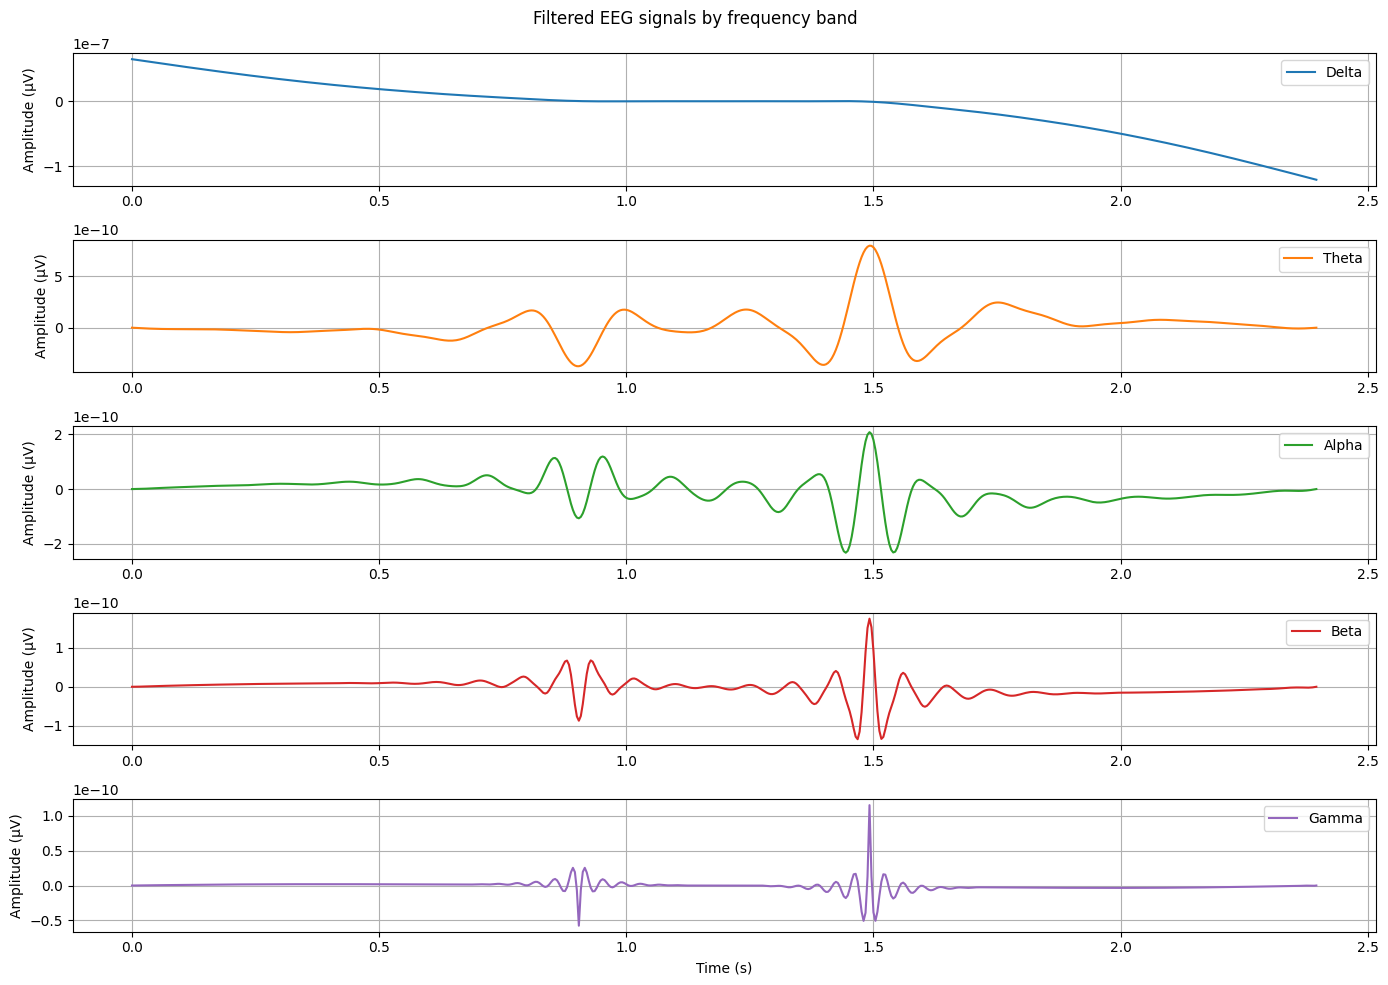

Bands enregistrées dans : ./band_outputs


In [6]:
# %matplotlib inline  # Décommente cette ligne si tu es dans Jupyter Notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import os

# 1. Charger les données EEG à partir d'un fichier CSV
def load_eeg_from_csv(file_path='/home/erick-mpangi/Documents/exerices-python/Jupyter/3.csv', sfreq=250, ch_names=None):
    data = pd.read_csv(file_path)

    # Filtrer les colonnes contenant uniquement des valeurs numériques
    numeric_data = data.select_dtypes(include=[np.number])

    if numeric_data.empty:
        raise ValueError("Le fichier CSV ne contient pas de colonnes numériques.")

    eeg_data = numeric_data.astype(float).values.T * 1e-6  # μV -> V (MNE utilise les volts)

    # Générer dynamiquement les noms des canaux si non fournis
    if ch_names is None:
        ch_names = [f'EEG{i+1}' for i in range(eeg_data.shape[0])]

    if eeg_data.shape[0] != len(ch_names):
        raise ValueError(f"Le nombre de canaux ({eeg_data.shape[0]}) ne correspond pas à len(ch_names) ({len(ch_names)}).")

    info = mne.create_info(
        ch_names=ch_names,
        sfreq=sfreq,
        ch_types=['eeg'] * len(ch_names)
    )

    raw = mne.io.RawArray(eeg_data, info)
    return raw

# 2. Prétraitement EEG
def preprocess_eeg(raw):
    # 1. Vérifier et nettoyer les données
    if 'eeg' not in raw:
        raw.set_channel_types({raw.ch_names[0]: 'eeg'})
    
    # Supprimer les NaN/Inf s'ils existent
    data = raw.get_data()
    if np.any(~np.isfinite(data)):
        print("Nettoyage des NaN/Inf trouvés dans les données")
        data[~np.isfinite(data)] = 0  # Remplacer par 0 ou une autre valeur
        raw = mne.io.RawArray(data, raw.info)
    
    # 2. Ajustement spécial pour les signaux courts
    max_filter_length = min(
        1000,  # Longueur maximale absolue
        int(raw.times[-1] * raw.info['sfreq'] * 0.8)  # 80% de la longueur du signal
    )
    
    # 3. Appliquer le filtre avec des paramètres adaptés
    try:
        raw.filter(0.5, 45, 
                 fir_design='firwin',
                 filter_length=f"{max_filter_length}s",
                 l_trans_bandwidth=0.5,
                 h_trans_bandwidth=11.25)
    except Exception as e:
        print(f"Erreur de filtrage : {e}")
        # Solution de secours pour les très courts signaux
        raw.filter(0.5, 45, method='iir')  # Filtre IIR plus adapté aux signaux courts
    
    # 4. ICA adaptée aux petits datasets
    n_components = min(5, len(raw.ch_names))  # Réduire le nombre de composantes
    try:
        ica = ICA(n_components=n_components, random_state=97, max_iter=200)
        ica.fit(raw.copy().crop(0, min(30, raw.times[-1])))  # Limiter la durée pour ICA
        ica.apply(raw)
    except Exception as e:
        print(f"Erreur ICA : {e}. Poursuite sans ICA.")
    
    return raw
# 3. Bandes EEG à extraire
EEG_BANDS = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 45)
}

# 4. Analyse EEG (filtrage, PSD)
def analyze_eeg_data(csv_path):
    try:
        raw = load_eeg_from_csv(csv_path, sfreq=250)  # plus besoin de ch_names manuels
        raw = preprocess_eeg(raw)

        bands_data = {}
        for band, (l_freq, h_freq) in EEG_BANDS.items():
            raw_band = raw.copy()
            if l_freq < 1:
                raw_band.filter(None, h_freq, fir_design='firwin', filter_length='auto')
            elif h_freq > 40:
                raw_band.filter(l_freq, None, fir_design='firwin', filter_length='auto')
            else:
                raw_band.filter(l_freq, h_freq, fir_design='firwin', filter_length='auto')
            bands_data[band] = raw_band.get_data()

        psds, freqs = {}, {}
        for band, data in bands_data.items():
            freqs[band], psds[band] = welch(data, raw.info['sfreq'], nperseg=min(256, data.shape[-1]//2))

        return raw, bands_data, psds, freqs
    except Exception as e:
        print(f"Erreur : {str(e)}")
        return None

# 5. Tracer les signaux EEG dans le temps
def plot_time_series(bands_data, sfreq):
    time = np.arange(bands_data['Alpha'].shape[-1]) / sfreq  # Axe des temps

    plt.figure(figsize=(14, 10))
    for i, (band, signal) in enumerate(bands_data.items()):
        signal_1d = signal[0] if signal.ndim == 2 else signal
        plt.subplot(len(bands_data), 1, i + 1)
        plt.plot(time, signal_1d, label=f'{band}', color=f'C{i}')
        plt.ylabel('Amplitude (µV)')
        plt.legend(loc='upper right')
        plt.grid(True)

    plt.xlabel('Time (s)')
    plt.suptitle('Filtered EEG signals by frequency band')
    plt.tight_layout()
    plt.show()

# 6. Sauvegarde optionnelle des signaux filtrés
def save_filtered_bands(bands_data, output_dir='./band_outputs'):
    os.makedirs(output_dir, exist_ok=True)
    for band, signal in bands_data.items():
        filename = os.path.join(output_dir, f'{band}_band.csv')
        pd.DataFrame(signal.T).to_csv(filename, index=False)
    print(f"Bands enregistrées dans : {output_dir}")

# 7. Exécution principale
if __name__ == "__main__":
    csv_path = '/home/erick-mpangi/Documents/exerices-python/Jupyter/3.csv'
    results = analyze_eeg_data(csv_path)

    if results:
        raw, bands_data, psds, freqs = results
        print("Analyse terminée avec succès !")
        plot_time_series(bands_data, raw.info['sfreq'])
        save_filtered_bands(bands_data)

Creating RawArray with float64 data, n_channels=13, n_times=347
    Range : 0 ... 346 =      0.000 ...     1.384 secs
Ready.
Nettoyage des NaN/Inf trouvés dans les données
Creating RawArray with float64 data, n_channels=13, n_times=347
    Range : 0 ... 346 =      0.000 ...     1.384 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 69001 samples (276.004 s)



/tmp/ipykernel_41877/3547993141.py:60: RuntimeWarning: filter_length (69001) is longer than the signal (347), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.5, 45,


Fitting ICA to data using 13 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 13 PCA components
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/home/erick-mpangi/Documents/exerices-python/.venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_41877/3547993141.py:99: RuntimeWarning: filter_length (413) is longer than the signal (347), distortion is likely. Reduce filter length or filter a longer signal.
  raw_band.filter(None, h_freq, fir_design='firwin', filter_length='auto')
/tmp/ipykernel_41877/3547993141.py:103: RuntimeWarning: filter_length (413) is longer than the signal (347), distortion is likely. Reduce filter length or filter a longer signal.
  raw_band.filter(l_freq, h_freq, fir_design='firwin', filter_length='auto')
/tmp/ipykernel_41877/3547993141.py:103: RuntimeWarning: filter_length (413) is longer than the signal (347), distortion is likely. Reduce filter length or filter a longer signal.
  raw_band.filter(l_freq, h_freq, fir_design='firwin', filter_l

Analyse terminée avec succès !


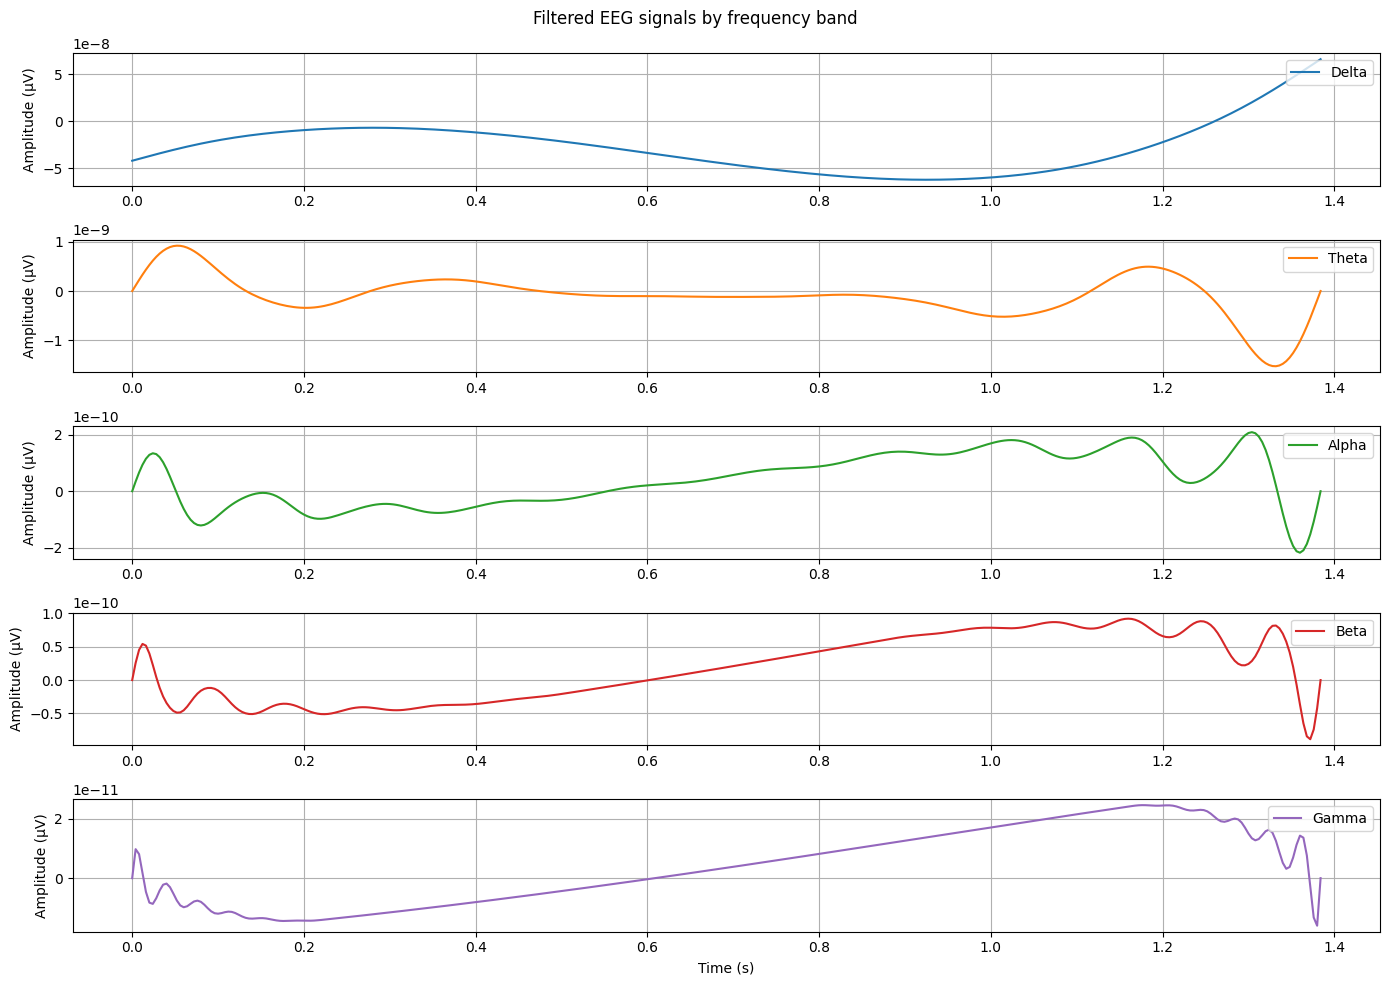

Bands enregistrées dans : ./band_outputs


In [7]:
# %matplotlib inline  # Décommente cette ligne si tu es dans Jupyter Notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
from mne.preprocessing import ICA
from scipy.signal import welch
import os

# 1. Charger les données EEG à partir d'un fichier CSV
def load_eeg_from_csv(file_path='/home/erick-mpangi/Documents/exerices-python/Jupyter/4.csv', sfreq=250, ch_names=None):
    data = pd.read_csv(file_path)

    # Filtrer les colonnes contenant uniquement des valeurs numériques
    numeric_data = data.select_dtypes(include=[np.number])

    if numeric_data.empty:
        raise ValueError("Le fichier CSV ne contient pas de colonnes numériques.")

    eeg_data = numeric_data.astype(float).values.T * 1e-6  # μV -> V (MNE utilise les volts)

    # Générer dynamiquement les noms des canaux si non fournis
    if ch_names is None:
        ch_names = [f'EEG{i+1}' for i in range(eeg_data.shape[0])]

    if eeg_data.shape[0] != len(ch_names):
        raise ValueError(f"Le nombre de canaux ({eeg_data.shape[0]}) ne correspond pas à len(ch_names) ({len(ch_names)}).")

    info = mne.create_info(
        ch_names=ch_names,
        sfreq=sfreq,
        ch_types=['eeg'] * len(ch_names)
    )

    raw = mne.io.RawArray(eeg_data, info)
    return raw

# 2. Prétraitement EEG
def preprocess_eeg(raw):
    # 1. Vérifier et nettoyer les données
    if 'eeg' not in raw:
        raw.set_channel_types({raw.ch_names[0]: 'eeg'})
    
    # Supprimer les NaN/Inf s'ils existent
    data = raw.get_data()
    if np.any(~np.isfinite(data)):
        print("Nettoyage des NaN/Inf trouvés dans les données")
        data[~np.isfinite(data)] = 0  # Remplacer par 0 ou une autre valeur
        raw = mne.io.RawArray(data, raw.info)
    
    # 2. Ajustement spécial pour les signaux courts
    max_filter_length = min(
        1000,  # Longueur maximale absolue
        int(raw.times[-1] * raw.info['sfreq'] * 0.8)  # 80% de la longueur du signal
    )
    
    # 3. Appliquer le filtre avec des paramètres adaptés
    try:
        raw.filter(0.5, 45, 
                 fir_design='firwin',
                 filter_length=f"{max_filter_length}s",
                 l_trans_bandwidth=0.5,
                 h_trans_bandwidth=11.25)
    except Exception as e:
        print(f"Erreur de filtrage : {e}")
        # Solution de secours pour les très courts signaux
        raw.filter(0.5, 45, method='iir')  # Filtre IIR plus adapté aux signaux courts
    
    # 4. ICA adaptée aux petits datasets
    n_components = min(5, len(raw.ch_names))  # Réduire le nombre de composantes
    try:
        ica = ICA(n_components=n_components, random_state=97, max_iter=200)
        ica.fit(raw.copy().crop(0, min(30, raw.times[-1])))  # Limiter la durée pour ICA
        ica.apply(raw)
    except Exception as e:
        print(f"Erreur ICA : {e}. Poursuite sans ICA.")
    
    return raw
# 3. Bandes EEG à extraire
EEG_BANDS = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 45)
}

# 4. Analyse EEG (filtrage, PSD)
def analyze_eeg_data(csv_path):
    try:
        raw = load_eeg_from_csv(csv_path, sfreq=250)  # plus besoin de ch_names manuels
        raw = preprocess_eeg(raw)

        bands_data = {}
        for band, (l_freq, h_freq) in EEG_BANDS.items():
            raw_band = raw.copy()
            if l_freq < 1:
                raw_band.filter(None, h_freq, fir_design='firwin', filter_length='auto')
            elif h_freq > 40:
                raw_band.filter(l_freq, None, fir_design='firwin', filter_length='auto')
            else:
                raw_band.filter(l_freq, h_freq, fir_design='firwin', filter_length='auto')
            bands_data[band] = raw_band.get_data()

        psds, freqs = {}, {}
        for band, data in bands_data.items():
            freqs[band], psds[band] = welch(data, raw.info['sfreq'], nperseg=min(256, data.shape[-1]//2))

        return raw, bands_data, psds, freqs
    except Exception as e:
        print(f"Erreur : {str(e)}")
        return None

# 5. Tracer les signaux EEG dans le temps
def plot_time_series(bands_data, sfreq):
    time = np.arange(bands_data['Alpha'].shape[-1]) / sfreq  # Axe des temps

    plt.figure(figsize=(14, 10))
    for i, (band, signal) in enumerate(bands_data.items()):
        signal_1d = signal[0] if signal.ndim == 2 else signal
        plt.subplot(len(bands_data), 1, i + 1)
        plt.plot(time, signal_1d, label=f'{band}', color=f'C{i}')
        plt.ylabel('Amplitude (µV)')
        plt.legend(loc='upper right')
        plt.grid(True)

    plt.xlabel('Time (s)')
    plt.suptitle('Filtered EEG signals by frequency band')
    plt.tight_layout()
    plt.show()

# 6. Sauvegarde optionnelle des signaux filtrés
def save_filtered_bands(bands_data, output_dir='./band_outputs'):
    os.makedirs(output_dir, exist_ok=True)
    for band, signal in bands_data.items():
        filename = os.path.join(output_dir, f'{band}_band.csv')
        pd.DataFrame(signal.T).to_csv(filename, index=False)
    print(f"Bands enregistrées dans : {output_dir}")

# 7. Exécution principale
if __name__ == "__main__":
    csv_path = '/home/erick-mpangi/Documents/exerices-python/Jupyter/4.csv'
    results = analyze_eeg_data(csv_path)

    if results:
        raw, bands_data, psds, freqs = results
        print("Analyse terminée avec succès !")
        plot_time_series(bands_data, raw.info['sfreq'])
        save_filtered_bands(bands_data)

In [1]:
pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 8.7 MB/s eta 0:00:00:00:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.5 MB/s eta 0:00:0000:0100:05m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 3.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 4.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 3.8 MB/s eta 0:00:0000:0100:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 4.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.3 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 3.2 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.
